In [22]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [11]:
def get_regression_data(n_train=7000, n_test=3000, n_dim=500, seed=114514):
    # Set random seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Generate random data
    X_train = np.random.randn(n_train, n_dim)
    X_test = np.random.randn(n_test, n_dim)
    
    # Generate epsilon noise
    epsilon_train = np.random.randn(n_train) * 0.01
    epsilon_test = np.random.randn(n_test) * 0.01
    
    # Calculate y_train and y_test
    y_train = 0.028 + np.sum(0.0056 * X_train, axis=1) + epsilon_train
    y_test = 0.028 + np.sum(0.0056 * X_test, axis=1) + epsilon_test
    
    return X_train, y_train, X_test, y_test

In [43]:
def get_classification_data():
    n_samples = 10000
    n_train = 7000
    n_test = 3000
    n_features = 200
    mu = 5.0
    sigma = 1.0
    seed = 114514
    
    # Set random seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Generate random data
    X1 = np.random.normal(mu, sigma, (n_samples, n_features))
    X2 = np.random.normal(-mu, sigma, (n_samples, n_features))
    y1 = np.zeros(n_samples)
    y2 = np.ones(n_samples)
    
    # Split data into train and test
    X1_train, X1_test = X1[:n_train], X1[n_train:]
    X2_train, X2_test = X2[:n_train], X2[n_train:]
    
    y1_train, y1_test = y1[:n_train], y1[n_train:]
    y2_train, y2_test = y2[:n_train], y2[n_train:]

    X_train = np.concatenate((X1_train, X2_train), axis=0)
    X_test = np.concatenate((X1_test, X2_test), axis=0)
    
    y_train = np.concatenate((y1_train, y2_train), axis=0)
    y_test = np.concatenate((y1_test, y2_test), axis=0)
    
    return X_train, y_train, X_test, y_test

In [13]:
def get_MNIST_data():
    train_data = torchvision.datasets.MNIST(root='./Datasets/MNIST', transform=transforms.ToTensor(), train=True, download=True)
    test_data = torchvision.datasets.MNIST(root='./Datasets/MNIST', transform=transforms.ToTensor(), train=False, download=True)
    
    return train_data, test_data

In [38]:
def draw_loss(train_loss, test_loss):
    x = np.linspace(0, len(train_loss), len(train_loss))
    plt.plot(x, train_loss, label="Train Loss", linewidth=1.5)
    plt.plot(x, test_loss, label="Test Loss", linewidth=1.5)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## 任务1：手动实现前馈神经网络解决上述回归、二分类、多分类任务

从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

In [41]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# 定义MSE Loss
def my_mse_loss(y_hat, y):
    return ((y_hat - y.view(y_hat.size())) ** 2).mean()

In [63]:
# 定义Cross-Entropy
def my_cross_entropy_loss(y_hat, labels):
    def log_softmax(y_hat):
        max_v = torch.max(y_hat, dim=1, keepdim=True).values
        return y_hat - max_v - torch.log(torch.exp(y_hat - max_v).sum(dim=1, keepdim=True))
    return (-log_softmax(y_hat))[range(len(y_hat)), labels.long()].mean()

In [49]:
def evaluate_accuracy(data_iter, model, loss_func):
    acc_sum, test_1_sum, n, c = 0.0, 0.0, 0, 0
    for X, y in data_iter:
        result = model.forward(X)
        acc_sum += (result.argmax(dim=1) == y).float().sum().item()
        test_1_sum += loss_func(result, y).item()
        n += y.shape[0]
        c += 1
    return acc_sum / n, test_1_sum / c

一、回归任务

In [23]:
# 准备数据
X_train, y_train, X_test, y_test = get_regression_data()
batch_size = 256

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create custom datasets
train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

# Create data loaders
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [35]:
# 定义模型
class Net():
    def __init__(self):
        # 定义并初始化模型参数
        num_inputs, num_outputs, num_hiddens = 500, 1, 256
        W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float)
        b1 = torch.zeros(num_hiddens, dtype=torch.float)
        W2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float)
        b2 = torch.zeros(num_outputs, dtype=torch.float)
        # 告知PyTorch框架，上述四个变量需要求梯度
        self.params = [W1, b1, W2, b2]
        for param in self.params:
            param.requires_grad = True
        
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_ReLU(torch.matmul(x, W1.t()) + b1)
        self.output_layer = lambda x: torch.matmul(x, W2.t()) + b2
    
    @staticmethod
    def my_ReLU(x):
        # 定义激活函数
        return torch.max(input=x, other=torch.tensor(0.0))
    
    def forward(self, x):
        # 定义模型前向传播过程
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        return final_output

In [19]:
# 定义优化算法
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad

In [36]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net.forward(X)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer(net.params, lr)
            # 梯度清零
            # optimizer.zero_grad()
            # 考虑到第一次进入训练循环，模型参数还没有梯度，所以把梯度清零放在最后
            for param in net.params:
                param.grad.data.zero_()
            train_1_sum += loss.item()
            # train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        # Accuracy removed for regression
        print('epoch %d, train loss %.4f, test loss %.4f' % (epoch + 1, train_1_sum / c, test_loss))
    return train_loss_list, test_loss_list

epoch 1, train loss 0.0168, test loss 0.0163
epoch 2, train loss 0.0161, test loss 0.0160
epoch 3, train loss 0.0159, test loss 0.0158
epoch 4, train loss 0.0156, test loss 0.0156
epoch 5, train loss 0.0154, test loss 0.0154
epoch 6, train loss 0.0152, test loss 0.0152
epoch 7, train loss 0.0149, test loss 0.0151
epoch 8, train loss 0.0148, test loss 0.0149
epoch 9, train loss 0.0145, test loss 0.0147
epoch 10, train loss 0.0145, test loss 0.0145
epoch 11, train loss 0.0142, test loss 0.0143
epoch 12, train loss 0.0139, test loss 0.0142
epoch 13, train loss 0.0138, test loss 0.0140
epoch 14, train loss 0.0136, test loss 0.0138
epoch 15, train loss 0.0134, test loss 0.0136
epoch 16, train loss 0.0132, test loss 0.0134
epoch 17, train loss 0.0130, test loss 0.0133
epoch 18, train loss 0.0128, test loss 0.0131
epoch 19, train loss 0.0125, test loss 0.0129
epoch 20, train loss 0.0123, test loss 0.0127
epoch 21, train loss 0.0121, test loss 0.0125
epoch 22, train loss 0.0119, test loss 0.01

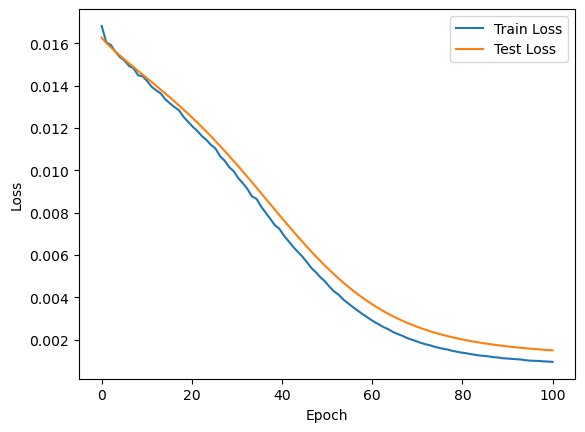

In [40]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 100
## 设置学习率
lr = 0.01
## 指定优化器为自定义的随机梯度下降
optimizer = SGD
## 初始化损失函数
loss = my_mse_loss

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
# 训练完成后绘制损失函数
draw_loss(train_loss, test_loss)

二、二分类任务

In [44]:
# 准备数据
X_train, y_train, X_test, y_test = get_classification_data()
batch_size = 256

# Create custom datasets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

# Create data loaders
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [45]:
# 定义模型
class Net():
    def __init__(self):
        # 定义并初始化模型参数
        num_inputs, num_outputs, num_hiddens = 200, 2, 256
        W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float)
        b1 = torch.zeros(num_hiddens, dtype=torch.float)
        W2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float)
        b2 = torch.zeros(num_outputs, dtype=torch.float)
        # 告知PyTorch框架，上述四个变量需要求梯度
        self.params = [W1, b1, W2, b2]
        for param in self.params:
            param.requires_grad = True
        
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_ReLU(torch.matmul(x, W1.t()) + b1)
        self.output_layer = lambda x: torch.matmul(x, W2.t()) + b2
    
    @staticmethod
    def my_ReLU(x):
        # 定义激活函数
        return torch.max(input=x, other=torch.tensor(0.0))
    
    def forward(self, x):
        # 定义模型前向传播过程
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        return final_output

In [46]:
# 定义优化算法
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad

In [47]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net.forward(X)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer(net.params, lr)
            # 梯度清零
            # optimizer.zero_grad()
            # 考虑到第一次进入训练循环，模型参数还没有梯度，所以把梯度清零放在最后
            for param in net.params:
                param.grad.data.zero_()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

epoch 1, train loss 0.0536, test loss 0.0042, train acc 0.987, test acc 1.000
epoch 2, train loss 0.0027, test loss 0.0018, train acc 1.000, test acc 1.000
epoch 3, train loss 0.0014, test loss 0.0011, train acc 1.000, test acc 1.000
epoch 4, train loss 0.0009, test loss 0.0008, train acc 1.000, test acc 1.000
epoch 5, train loss 0.0007, test loss 0.0006, train acc 1.000, test acc 1.000


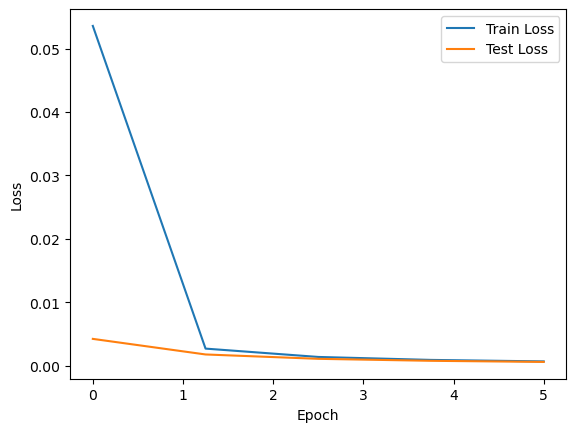

In [52]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 5
## 设置学习率
lr = 0.01
## 指定优化器为自定义的随机梯度下降
optimizer = SGD
## 初始化损失函数
loss = my_cross_entropy_loss

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
# 训练完成后绘制损失函数
draw_loss(train_loss, test_loss)

二、多分类任务

In [54]:
# 准备数据
train_data, test_data = get_MNIST_data()
batch_size = 256

# Create custom datasets
train_dataset = MyDataset(train_data.data, train_data.targets)
test_dataset = MyDataset(test_data.data, test_data.targets)

# Create data loaders
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

C:\Users\Jemzh\AppData\Local\Temp\ipykernel_23172\1997184050.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Jemzh\AppData\Local\Temp\ipykernel_23172\1997184050.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [65]:
# 定义模型
class Net():
    def __init__(self):
        # 定义并初始化模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float)
        b1 = torch.zeros(num_hiddens, dtype=torch.float)
        W2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float)
        b2 = torch.zeros(num_outputs, dtype=torch.float)
        # 告知PyTorch框架，上述四个变量需要求梯度
        self.params = [W1, b1, W2, b2]
        for param in self.params:
            param.requires_grad = True
        
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_ReLU(torch.matmul(x, W1.t()) + b1)
        self.output_layer = lambda x: torch.nn.functional.softmax(torch.matmul(x, W2.t()) + b2)
    
    @staticmethod
    def my_ReLU(x):
        # 定义激活函数
        return torch.max(input=x, other=torch.tensor(0.0))
    
    def forward(self, x):
        # 定义模型前向传播过程
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        return final_output

In [60]:
# 定义优化算法
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad

In [61]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net.forward(X)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer(net.params, lr)
            # 梯度清零
            # optimizer.zero_grad()
            # 考虑到第一次进入训练循环，模型参数还没有梯度，所以把梯度清零放在最后
            for param in net.params:
                param.grad.data.zero_()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

C:\Users\Jemzh\AppData\Local\Temp\ipykernel_23172\584790511.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.output_layer = lambda x: torch.nn.functional.softmax(torch.matmul(x, W2.t()) + b2)


epoch 1, train loss 1.6942, test loss 1.5524, train acc 0.771, test acc 0.913
epoch 2, train loss 1.5274, test loss 1.5217, train acc 0.939, test acc 0.941
epoch 3, train loss 1.5102, test loss 1.5161, train acc 0.955, test acc 0.948
epoch 4, train loss 1.5014, test loss 1.5040, train acc 0.963, test acc 0.959
epoch 5, train loss 1.4950, test loss 1.4994, train acc 0.969, test acc 0.964
epoch 6, train loss 1.4907, test loss 1.4953, train acc 0.974, test acc 0.968
epoch 7, train loss 1.4870, test loss 1.4925, train acc 0.977, test acc 0.970
epoch 8, train loss 1.4841, test loss 1.4909, train acc 0.980, test acc 0.972
epoch 9, train loss 1.4820, test loss 1.4907, train acc 0.982, test acc 0.972
epoch 10, train loss 1.4802, test loss 1.4900, train acc 0.983, test acc 0.973
epoch 11, train loss 1.4784, test loss 1.4940, train acc 0.985, test acc 0.969
epoch 12, train loss 1.4774, test loss 1.4974, train acc 0.986, test acc 0.965
epoch 13, train loss 1.4759, test loss 1.4873, train acc 0.98

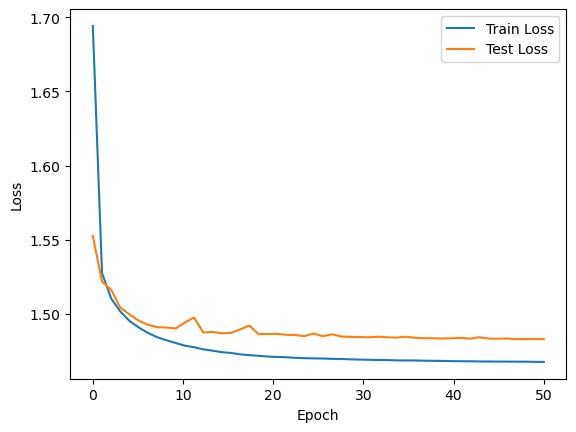

In [66]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为自定义的随机梯度下降
optimizer = SGD
## 初始化损失函数
loss = my_cross_entropy_loss

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
# 训练完成后绘制损失函数
draw_loss(train_loss, test_loss)

## 任务2：调用PyTorch实现前馈神经网络解决上述回归、二分类、多分类任务

从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

In [91]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, X, y, task_type='regression'):
        self.X = torch.tensor(X, dtype=torch.float32)
        if task_type == 'classification':
            self.y = torch.tensor(y, dtype=torch.long)
        else:
            self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

1. 回归任务

In [92]:
# 准备数据
X_train, y_train, X_test, y_test = get_regression_data()
batch_size = 256

# Create custom datasets for classification tasks
train_dataset = MyDataset(X_train, y_train, task_type='classification')
test_dataset = MyDataset(X_test, y_test, task_type='classification')

# Create data loaders
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [74]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 500, 1, 256
        
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        
        # 初始化模型参数
        for hidden_layer in self.hidden_layer.parameters():
            nn.init.normal_(hidden_layer, mean=0, std=0.01)
        for output_layer in self.output_layer.parameters():
            nn.init.normal_(output_layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

In [75]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f' % (epoch + 1, train_1_sum / c, test_loss))
    return train_loss_list, test_loss_list

C:\Users\Jemzh\anaconda3\envs\ctr_torch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Jemzh\anaconda3\envs\ctr_torch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Jemzh\anaconda3\envs\ctr_torch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([184])) that is different to the input size (torch.Size([184, 1])). This will likely lead to incorrect results due to broadcasting. Please 

epoch 1, train loss 0.0170, test loss 0.0162
epoch 2, train loss 0.0160, test loss 0.0160
epoch 3, train loss 0.0159, test loss 0.0160
epoch 4, train loss 0.0160, test loss 0.0160
epoch 5, train loss 0.0159, test loss 0.0160
epoch 6, train loss 0.0159, test loss 0.0160
epoch 7, train loss 0.0159, test loss 0.0160
epoch 8, train loss 0.0159, test loss 0.0160
epoch 9, train loss 0.0159, test loss 0.0159
epoch 10, train loss 0.0159, test loss 0.0159
epoch 11, train loss 0.0159, test loss 0.0159
epoch 12, train loss 0.0159, test loss 0.0159
epoch 13, train loss 0.0159, test loss 0.0159
epoch 14, train loss 0.0159, test loss 0.0159
epoch 15, train loss 0.0159, test loss 0.0159
epoch 16, train loss 0.0158, test loss 0.0159
epoch 17, train loss 0.0159, test loss 0.0159
epoch 18, train loss 0.0158, test loss 0.0159
epoch 19, train loss 0.0158, test loss 0.0159
epoch 20, train loss 0.0158, test loss 0.0159
epoch 21, train loss 0.0159, test loss 0.0159
epoch 22, train loss 0.0159, test loss 0.01

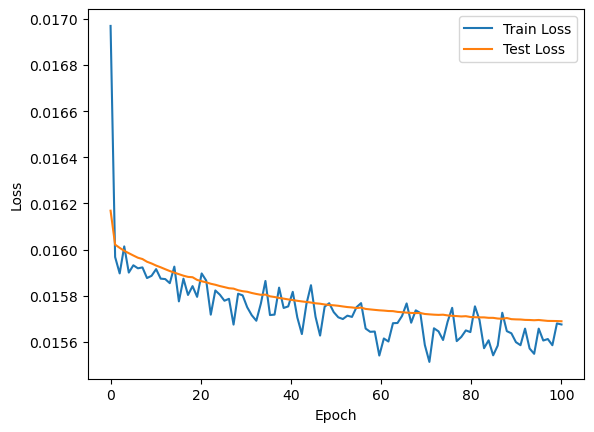

In [76]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 100
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.MSELoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
# 训练完成后绘制损失函数
draw_loss(train_loss, test_loss)

2. 二分类任务

In [114]:
# 准备数据
X_train, y_train, X_test, y_test = get_classification_data()
batch_size = 256

train_dataset = MyDataset(X_train, y_train, task_type='classification')
test_dataset = MyDataset(X_test, y_test, task_type='classification')

train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [115]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 200, 2, 256
        
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        
        # 初始化模型参数
        for hidden_layer in self.hidden_layer.parameters():
            nn.init.normal_(hidden_layer, mean=0, std=0.01)
        for output_layer in self.output_layer.parameters():
            nn.init.normal_(output_layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

In [116]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

epoch 1, train loss 0.3560, test loss 0.3182, train acc 0.993, test acc 1.000
epoch 2, train loss 0.3164, test loss 0.3153, train acc 1.000, test acc 1.000
epoch 3, train loss 0.3148, test loss 0.3145, train acc 1.000, test acc 1.000
epoch 4, train loss 0.3143, test loss 0.3141, train acc 1.000, test acc 1.000
epoch 5, train loss 0.3140, test loss 0.3139, train acc 1.000, test acc 1.000
epoch 6, train loss 0.3138, test loss 0.3138, train acc 1.000, test acc 1.000
epoch 7, train loss 0.3137, test loss 0.3137, train acc 1.000, test acc 1.000
epoch 8, train loss 0.3137, test loss 0.3136, train acc 1.000, test acc 1.000
epoch 9, train loss 0.3136, test loss 0.3136, train acc 1.000, test acc 1.000
epoch 10, train loss 0.3136, test loss 0.3135, train acc 1.000, test acc 1.000
epoch 11, train loss 0.3135, test loss 0.3135, train acc 1.000, test acc 1.000
epoch 12, train loss 0.3135, test loss 0.3135, train acc 1.000, test acc 1.000
epoch 13, train loss 0.3135, test loss 0.3135, train acc 1.00

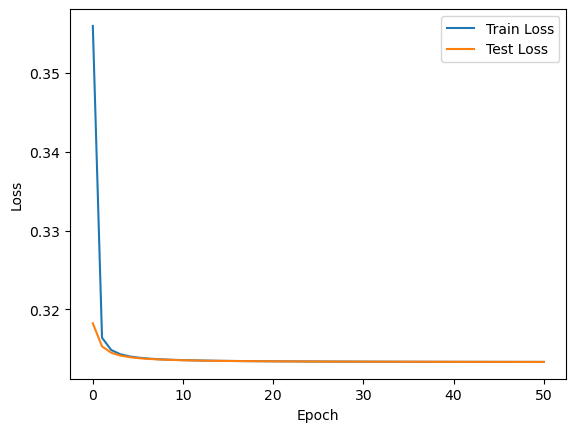

In [117]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
# 训练完成后绘制损失函数
draw_loss(train_loss, test_loss)

3. 多分类任务

In [118]:
# 准备数据
train_data, test_data = get_MNIST_data()
batch_size = 256

train_dataset = MyDataset(train_data.data, train_data.targets, task_type='classification')
test_dataset = MyDataset(test_data.data, test_data.targets, task_type='classification')

train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

C:\Users\Jemzh\AppData\Local\Temp\ipykernel_23172\1706069175.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Jemzh\AppData\Local\Temp\ipykernel_23172\1706069175.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


In [122]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(num_hiddens, num_outputs),
            nn.Softmax(dim=1)
        )
        
        # 初始化模型参数
        for hidden_layer in self.hidden_layer.parameters():
            nn.init.normal_(hidden_layer, mean=0, std=0.01)
        for output_layer in self.output_layer.parameters():
            nn.init.normal_(output_layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

In [123]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

epoch 1, train loss 1.6283, test loss 1.5361, train acc 0.838, test acc 0.929
epoch 2, train loss 1.5252, test loss 1.5164, train acc 0.941, test acc 0.948
epoch 3, train loss 1.5095, test loss 1.5140, train acc 0.956, test acc 0.949
epoch 4, train loss 1.5005, test loss 1.5022, train acc 0.965, test acc 0.962
epoch 5, train loss 1.4946, test loss 1.5018, train acc 0.970, test acc 0.961
epoch 6, train loss 1.4900, test loss 1.5020, train acc 0.974, test acc 0.962
epoch 7, train loss 1.4867, test loss 1.4952, train acc 0.977, test acc 0.967
epoch 8, train loss 1.4839, test loss 1.4947, train acc 0.980, test acc 0.968
epoch 9, train loss 1.4819, test loss 1.4919, train acc 0.982, test acc 0.970
epoch 10, train loss 1.4799, test loss 1.4898, train acc 0.984, test acc 0.973
epoch 11, train loss 1.4787, test loss 1.4890, train acc 0.985, test acc 0.974
epoch 12, train loss 1.4772, test loss 1.4879, train acc 0.986, test acc 0.975
epoch 13, train loss 1.4762, test loss 1.4880, train acc 0.98

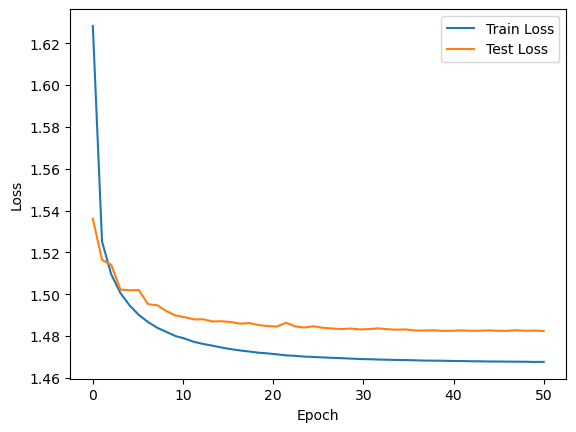

In [125]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
# 训练完成后绘制损失函数
draw_loss(train_loss, test_loss)